<a href="https://colab.research.google.com/github/saeu5407/daily_tensorflow/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

이번에는 텐서플로우 튜토리얼 중 심층 합성곱 생성적 적대 신경망(DCGAN)에 대해 실습하겠습니다.

### DCGAN이란

요즘 자주 쓰이는 아이디어로, 두 개의 모델이 적대적인 과정을 통해 동시에 훈련을 하는 기법입니다.
각 모델을 생성자, 감별자라고 합니다.

각 모델은 다음과 같이 학습되게 됩니다.
생성자 : 진짜처럼 보이는 이미지를 생성.
감별자 : 생성자가 생성한 이미지가 가짜인지 구별.

훈련과정 동안 생성자는 점차 실제같은 이미지를 더 잘 생성하게 되고, 감별자는 점차 진짜와 가짜를 더 잘 구별하게됩니다. 이 과정은 감별자가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달하게 됩니다.

텐서플로우 튜토리얼 원본 링크 [텐서플로우 DCGAN](https://https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)

In [1]:
!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf
tf.__version__

'2.0.0-rc1'

In [2]:
# GIF를 만들기위해 설치합니다.
!pip install -q imageio

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 데이터셋 로드 및 준비

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 모델링

#### 생성자
생성자는 시드값으로부터 이미지를 생성하기 위해, tf.keras.layers.Conv2DTranspose(업샘플링) 층을 이용합니다. 처음 Dense층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 tf.keras.layers.LeakyReLU을 사용하고 있음을 주목합시다.

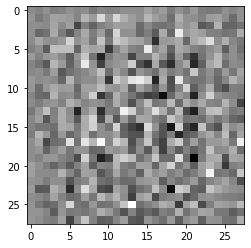

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    # Conv2DTranspose 적용 부분, 최종적으로 28x28의 크기로 스케일을 올린다.
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

생성자의 손실함수는 감별자에 대한 수치화 지표입니다. 생성된 이미지에 대한 감별자의 결정과 1로 이루어진 행렬을 비교합니다.

In [6]:
# 생성자 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### 감별자(Discriminator)

합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다.

감별자를 사용하여 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

In [7]:
# Discriminator
"""
일반적인 CNN 모델
"""
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0028537]], shape=(1, 1), dtype=float32)


감별자의 손실함수는
진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬 두 가지를 비교하고,<br> 가짜 (생성된)이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 감별자 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
# 두 모델이 다르기 때문에 옵티마이저를 따로 구성합니다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### 모델 구현부

In [10]:
# 체크포인트 저장
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 시드 고정 및 각 파라미터 고정
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [11]:
# 모델 훈련 함수(메인 함수에 들어갈 예정)
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
"""
@tf.function은 tf1.x 스타일로 함수 내 로직이 동작하게끔 해 주는 방법입니다.
현재 tf2.x이상 버젼에서는 tf.Session등 추가적인 방법 없이 간편하게 돌아가게끔 구성이 되어 있지만, 
그래프의 생성과 실행이 분리되어 있는 tf1.x가 속도에 이점이 있을 수 있습니다.
다만 해당 annotation을 붙이면 값을 바로 계산해볼수 없어서 모든 로직에 대한 프로그래밍이 끝난 뒤에 붙이는 것이 좋다고 합니다.
"""
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # 랜덤함수로 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # with as를 이렇게 ,를 활용하여 쓸 수 있음.
      # tf.GradientTape()는 자동 미분을 도와주는 함수로, 모든 연산을 테이프(tape)에 기록 후 기록 된 연산의 그래디언트를 계산합니다.
      generated_images = generator(noise, training=True) # 생성자

      real_output = discriminator(images, training=True) # 이미지에 대한 판별
      fake_output = discriminator(generated_images, training=True) # 생성자가 만든 이미지에 대한 판별

      # 각 Loss 계산
      gen_loss = generator_loss(fake_output) 
      disc_loss = discriminator_loss(real_output, fake_output)

    # 그래디언트 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 오차역전파 업데이트
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
# 이미지 생성 함수
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch)) # %04d는 %0d가 4자리수까지 된다고 보면 편하다. 즉 0000 네자리수로 변환
  plt.show()

In [13]:
# 메인 훈련 함수
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    # 위의 훈련 함수를 통해 훈련 수행
    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

#### 모델 훈련

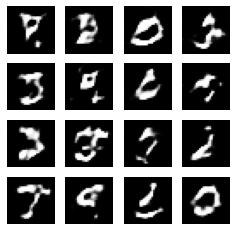

Time for epoch 24 is 826.3127543926239 sec


In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# 샘플 이미지 시각화
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

#### 추가 : GIF 생성 및 저장

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)